In [1]:
%pip install geopandas
%pip install pyrosm
%pip install gtfs_kit
%pip install h3
%pip install keplergl
%pip install matplotlib
%pip install esy-osmfilter
%pip install rasterio

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 19.2 MB 253 kB/s eta 0:00:01    |██▋                             | 1.5 MB 3.3 MB/s eta 0:00:06     |███████████▉                    | 7.1 MB 3.3 MB/s eta 0:00:04
Note: you may need to restart the kernel to use updated packages.


In [6]:
import sys
from pathlib import Path
import json
import h3

import pandas as pd
import numpy as np
import geopandas as gp
import matplotlib

import gtfs_kit as gk

from shapely.geometry import mapping, shape

/home/jacdals97/anaconda3/envs/transit/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
path = "../resources/rejseplanen.zip"
feed = gk.read_feed(path, dist_units='km')

dates = ['20220320', '20220321', '20220322', '20220323', '20220324', '20220325', '20220326']

In [3]:
stops = feed.stops

stops['h3'] = stops.apply(lambda row: h3.geo_to_h3(row['stop_lat'],row['stop_lon'],10), axis=1)
stops.head()

stop_h3_map = pd.Series(stops.h3.values,index=stops.stop_id).to_dict()

In [ ]:
geojson = feed.routes_to_geojson(include_stops=True)

In [8]:
with open("geojson.json", "w") as outfile:
    json.dump(geojson, outfile)

In [4]:
ts = feed.compute_stop_time_series(dates=dates, freq='60Min')
ts.shape

(168, 38276)

In [5]:
tts = ts.transpose().reset_index(level=1)
tts.head()

datetime,stop_id,2022-03-20 00:00:00,2022-03-20 01:00:00,2022-03-20 02:00:00,2022-03-20 03:00:00,2022-03-20 04:00:00,2022-03-20 05:00:00,2022-03-20 06:00:00,2022-03-20 07:00:00,2022-03-20 08:00:00,...,2022-03-26 14:00:00,2022-03-26 15:00:00,2022-03-26 16:00:00,2022-03-26 17:00:00,2022-03-26 18:00:00,2022-03-26 19:00:00,2022-03-26 20:00:00,2022-03-26 21:00:00,2022-03-26 22:00:00,2022-03-26 23:00:00
indicator,,,,,,,,,,,,,,,,,,,,,
num_trips,000000000006,2.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,...,6.0,6.0,5.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0
num_trips,000000000008,2.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,...,6.0,6.0,5.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0
num_trips,000000000009,2.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,...,6.0,6.0,5.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0
num_trips,000000000011,3.0,1.0,1.0,1.0,1.0,2.0,4.0,8.0,8.0,...,17.0,17.0,16.0,10.0,9.0,9.0,8.0,9.0,8.0,8.0
num_trips,000000000012,2.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,5.0,...,9.0,9.0,8.0,6.0,6.0,6.0,5.0,6.0,5.0,5.0


In [6]:
def add_lists(lists):
    res = np.array([0]*len(lists[0]))
    for i in range(len(lists)-1):
        l = np.array(lists[i])
        l = np.nan_to_num(l)
        # print(f"adding res with {np.shape(res)} and list with {np.shape(l)}")
        res = np.add(res, l)
        # print(f"resulting shape: {np.shape(res)}")
    return res

In [7]:
result_df = pd.DataFrame()
# result_df['h3'] = tts.apply(lambda row: stop_h3_map[row['stop_id']], axis=1)
result_df['stop_id'] = tts['stop_id'].values.tolist()
result_df['h3'] = result_df.apply(lambda row: stop_h3_map[row['stop_id']], axis=1)
result_df['frequency'] = tts.iloc[:,1:].values.tolist()

unique_h3s = set(stop_h3_map.values())
h3_map = {}
for index in unique_h3s:
    res = result_df.loc[result_df['h3'] == index]
    if res.shape[0] > 1:
        res = add_lists(res['frequency'].values.tolist())
        h3_map[index] = res.tolist()
    elif res['frequency'].any():
        h3_map[index] = np.nan_to_num(res['frequency'].values[0]).tolist()
    

In [8]:
new = pd.DataFrame()
new['h3'] = h3_map.keys()
new['freq'] = h3_map.values()
new.head()

,h3,freq
0,8a1f0425e1a7fff,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,8a1f230dc557fff,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,8a1f230432e7fff,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,8a1f26030607fff,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,8a1f246d6097fff,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, ..."


In [ ]:
new.to_csv("data.csv")

In [ ]:
time_cols = tts.columns[1:]

In [ ]:
insane_array = []
for key, value in h3_map.items():
    for i, v in enumerate(value):
        insane_array.append([key, str(time_cols[i]), v])

insane_df = pd.DataFrame(insane_array, columns=['hex_id', 'time', 'height'])

In [ ]:
from keplergl import KeplerGl
map = KeplerGl(height=500, data={'data': insane_df})
map.save_to_html()

### Read in data from osm_convert.py

In [11]:
import json
with open('dkall.geojson') as json_file:
    data = json.load(json_file)


print(data['features'][0])
for geo in data['features']:
    geo['geometry']['coordinates'] =  [[y,x] for x,y in geo['geometry']['coordinates']]

print(data['features'][0])


{'type': 'Feature', 'OSM-id': 2081, 'geometry': {'type': 'LineString', 'coordinates': [[12.068616900000002, 55.63906129999988], [12.068575599999985, 55.63924110000002], [12.068572399999985, 55.63925310000002], [12.068513299999985, 55.63947020000002], [12.068505499999985, 55.63949900000002], [12.068481799999985, 55.63958620000002], [12.068464999999986, 55.639647900000014], [12.068336000000018, 55.64012210000009], [12.068039499999996, 55.64127480000004], [12.0680057, 55.64140629999993], [12.067493399999968, 55.64315839999993], [12.067267600000006, 55.64391739999991], [12.067134999999988, 55.64428009999988], [12.067132999999988, 55.644330099999884], [12.067133699999989, 55.64436989999988], [12.06709269999999, 55.644525199999876], [12.067073900000047, 55.64459120000007], [12.0669844, 55.64488570000034], [12.066940200000007, 55.645036699999906], [12.06662590000002, 55.64611490000006], [12.066515300000045, 55.646507399999734], [12.066376499999956, 55.64699540000023], [12.066336100000006, 55.

# Transform

In [126]:
from pyproj import Transformer, CRS


crs_4326 = CRS.from_epsg(4326)
crs_25831 = CRS.from_epsg(25832)

to_dk = Transformer.from_crs(crs_4326, crs_25831)
to_WGS = Transformer.from_crs(crs_25831, crs_4326)


def CRS_transform(shp, inv=False):
    geoInterface = shp.__geo_interface__

    shpType = geoInterface['type']
    coords = geoInterface['coordinates']
    if shpType == 'Polygon':
        if inv:
            newCoord = [[to_WGS.transform(*point) for point in linring] for linring in coords]
        else:
            newCoord = [[to_dk.transform(*point) for point in linring] for linring in coords]
    elif shpType == 'LineString':
        if inv:
            newCoord = [to_WGS.transform(*point) for point in coords]
        else:
            newCoord = [to_dk.transform(*point) for point in coords]
    elif shpType == 'MultiPolygon':
        if inv:
            newCoord = [[[to_WGS.transform(*point) for point in linring] for linring in poly] for poly in coords]
        else:
            newCoord = [[[to_dk.transform(*point) for point in linring] for linring in poly] for poly in coords]

    return shape({'type': shpType, 'coordinates': tuple(newCoord)})

# Polyfill method

In [ ]:
from shapely.geometry import mapping, shape

#consider how buffer works for WSG82

h3_set = set()
for geo in data['features']:
    tmp = shape(geo['geometry'])
    tmp = CRS_transform(tmp)
    tmp = tmp.buffer(10)
    tmp = CRS_transform(tmp, inv = True)

    if mapping(tmp)['type'] == 'Polygon':
        h3_set.update(h3.polyfill(mapping(tmp), 11, geo_json_conformant=False))
    elif mapping(tmp)['type'] == 'MultiPolygon':
        polygons = list(tmp)
        for poly in polygons:
            h3_set.update(h3.polyfill(mapping(poly), 11, geo_json_conformant=False))
    else:
        break
    

In [129]:
walk = pd.DataFrame(list(h3_set), columns=['h3'])
walk['x'] = 1
walk.to_csv("walk_paths_15m.csv")

# H3 line method

In [12]:

h3_set = set()
for geo in data['features']:
    tmp = shape(geo['geometry'])
    if len(mapping(tmp)['coordinates']) == 1:
        h3_set.add(h3.geo_to_h3(*mapping(tmp)['coordinates'], resolution = 11))
    for i in range(len(mapping(tmp)['coordinates']) - 1):
        h3s = h3.h3_line( h3.geo_to_h3(*mapping(tmp)['coordinates'][i], resolution = 11) , h3.geo_to_h3(*mapping(tmp)['coordinates'][i+1], resolution = 11) )
        h3_set.update(h3s)

In [ ]:
walk = pd.DataFrame(list(h3_set), columns=['h3'])
walk.to_csv("line_paths_11.csv")

# H3 edges method

In [175]:
h3_set = set()
for geo in data['features']:
    tmp = shape(geo['geometry'])
    if len(mapping(tmp)['coordinates']) == 1:
        continue
        h3_set.add(h3.geo_to_h3(*mapping(tmp)['coordinates'], resolution = 11))
    for i in range(len(mapping(tmp)['coordinates']) - 1):
        h3s = h3.h3_line( h3.geo_to_h3(*mapping(tmp)['coordinates'][i], resolution = 11) , h3.geo_to_h3(*mapping(tmp)['coordinates'][i+1], resolution = 11) )
        h3_edges = [h3.get_h3_unidirectional_edge(h3s[i], h3s[i+1]) for i in range(len(h3s) -1)]
        h3_set.update(h3_edges)


In [ ]:
walk = pd.DataFrame(list(h3_set), columns=['h3'])
walk.to_csv("edges_paths_11.csv")

# Line interpolation

In [153]:
from shapely.geometry import mapping, shape, LineString
import numpy as np


h3_set = set()
for geo in data['features']:
    tmp = shape(geo['geometry'])
    tmp = CRS_transform(tmp)
    distances = np.arange(0, tmp.length, 10)
    points = [tmp.interpolate(distance) for distance in distances] 
    if len(points) == 1:
        continue
    tmp = LineString(points)
    tmp = CRS_transform(tmp, inv = True)
    h3s = {h3.geo_to_h3(lat, lon, 11) for (lat, lon) in mapping(tmp)['coordinates']}
    h3_set.update(h3s)
    

KeyboardInterrupt: 

In [161]:
walk = pd.DataFrame(list(h3_set), columns=['h3'])
walk['x'] = 1
walk.to_csv("line_paths_11.csv")

# Reading EU urbanization data

We work with raster image

In [82]:
import rasterio
import os
import csv
import matplotlib.pyplot as plt
from matplotlib import colors
from rasterio.plot import show
import rasterio.warp
from rasterio.crs import CRS

In [97]:
def get_colormap(fn):
    if not os.path.exists(fn):
        raise IOError("File not found!")
    with open(fn) as cf:
        colormgr = csv.reader(cf, delimiter=' ')
        result = {}
        for row in colormgr:
            color = [int(row[1]), int(row[2]), int(row[3])]
            result[int(row[0])] = color
    return result

cmap_dict = get_colormap('L2_colcod.tif.clr')

cols = [color for color in cmap_dict.values()]

bounds=[10,11,12,13,21,22,23,30]

my_cmap = colors.ListedColormap(cols)
norm = colors.BoundaryNorm(bounds, my_cmap.N)

<AxesSubplot:>

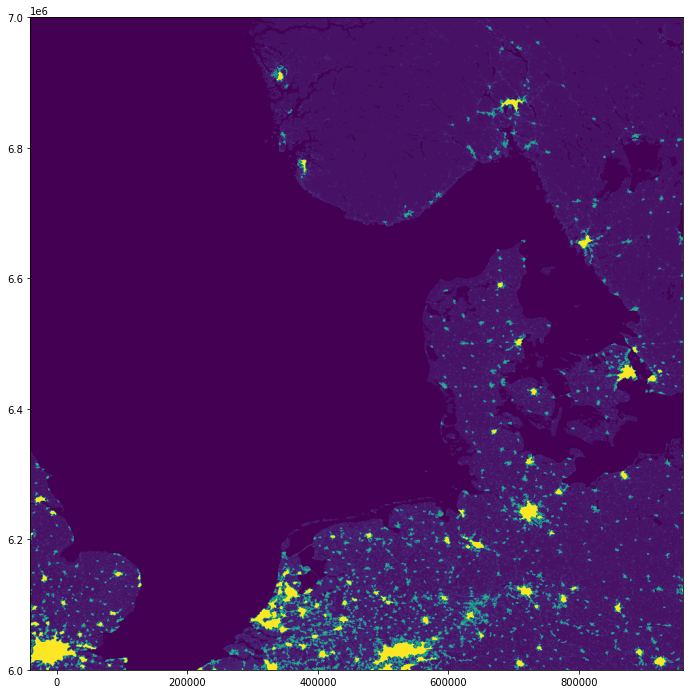

In [90]:
fp = r'GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K_V2_0_18_2.tif'
img = rasterio.open(fp)
fig, ax = plt.subplots(1, figsize=(12, 12))
show(img, ax=ax)

In [187]:
h3_set = dict()
fps = ['GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K_V2_0_18_2.tif','GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K_V2_0_19_2.tif']
for fp in fps:
    with rasterio.open(fp) as src:
        band1 = src.read(1)
        print('Band1 has shape', band1.shape)
        height = band1.shape[0]
        width = band1.shape[1]
        cols, rows = np.meshgrid(np.arange(width), np.arange(height))
        xs, ys = rasterio.transform.xy(src.transform, rows, cols)
        lons= np.array(xs)
        lats = np.array(ys)
        print('lons shape', lons.shape)
        xs_t, ys_t = rasterio.warp.transform(
            CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],\
                AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],\
                PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
            CRS.from_epsg(4326),
            xs = lons.flatten(),
            ys = lats.flatten()
        )
        for x,y, val in zip(xs_t, ys_t, band1.flatten()):
            if val in [22, 23, 30]: #urban pixel values
                h3_set[h3.geo_to_h3(y,x, resolution=7)] = 1
            elif val in [11,12,13, 21]: #rural pixel values
                h3_set[h3.geo_to_h3(y,x, resolution=7)] = 0


        

Band1 has shape (1000, 1000)
lons shape (1000, 1000)
Band1 has shape (1000, 1000)
lons shape (1000, 1000)


In [113]:
import rasterio.warp
from rasterio.crs import CRS

# Project the feature to the desired CRS
xs_t, ys_t = rasterio.warp.transform(
    CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],\
        AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],\
        PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
    CRS.from_epsg(4326),
    xs = lons.flatten(),
    ys = lats.flatten()
)

In [188]:

walk = pd.DataFrame.from_dict(h3_set, orient="index", columns=['urban'])
walk.to_csv("urb_projection.csv")

In [178]:
dtu = pd.read_pickle('Figure_3.pkl')
dtu = dtu[dtu['NAME_0']=='Denmark']
dtu = dtu[dtu.sizes.apply(lambda x: len(x) != 0)]

In [179]:
l_2 = []
for sizes in dtu['sizes']:
    l_2.append(sizes[0])


In [180]:
dtu['l_2'] = l_2

In [206]:
def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 2)
    upper_limit = s.mean() + (s.std() * 2)
    return ~s.between(lower_limit, upper_limit)

In [207]:
urban = dtu[dtu.urban_rural == 'urban']
urban.groupby('n_scales').describe()
urban[~urban.groupby('n_scales')['l_2'].apply(is_outlier)].groupby('n_scales').describe()

l_2                                                       \
          count          mean           std         min          25%   
n_scales                                                               
2          82.0  14508.084961  21234.312500  285.961792  1632.171997   
3         186.0  14327.533203  17114.226562  167.468597  1918.677795   
4         316.0   4810.480957   5615.419434  114.939392  1242.044708   
5         291.0   2433.532959   2566.668213  118.149559   833.083252   
6         158.0   1944.513062   1767.174805   78.769814   733.903885   
7          76.0   1919.104858   2223.351074  230.631470   805.153015   
8          26.0   2050.080811   2628.405518  116.235931   751.636597   
9           5.0   2038.586670   2736.440186  373.983887   402.457520   

                                                    
                  50%           75%            max  
n_scales                                            
2         4471.490479  16663.134766  100218.648438  
3         5222.741455  23858.986328   69530.312500  
4         2735.477783   6091.992310   30794.310547  
5         1565.716187   3008.244995   14420.225586  
6         1326.483582   2691.697205    9457.055664  
7         1153.721619   2066.189880   10583.246094  
8         1003.399078   1760.625885   10648.540039  
9          574.482849   2074.819580    6767.189941

In [208]:
rural = dtu[dtu.urban_rural == 'rural']
rural[~rural.groupby('n_scales')['l_2'].apply(is_outlier)].groupby('n_scales').describe()
#rural.groupby('n_scales').describe()


l_2                                                       \
          count          mean           std         min          25%   
n_scales                                                               
2         227.0  21384.593750  20768.109375  118.836937  5224.340332   
3         246.0  22175.462891  20969.191406  111.690071  5426.192383   
4         388.0  11203.541016  11107.312500   60.698612  1987.711426   
5         301.0   7198.330566   7660.017578   61.800449  1395.271362   
6         186.0   3504.908691   4253.396973   46.262280   807.431732   
7          69.0   2308.512695   2144.171143   66.295006   721.867859   
8          14.0   1871.088867   2291.001465   75.986732   671.452774   
9           8.0   1691.542236   1014.292786  259.623169   969.178986   
10          3.0    836.065125    548.749756  256.207367   580.477417   

                                                    
                   50%           75%           max  
n_scales                                            
2         14652.738281  29828.399414  96306.187500  
3         15316.430664  33522.144531  86752.890625  
4          7213.781250  17976.384277  47116.746094  
5          4135.174316  11160.869141  38732.171875  
6          1628.992920   4384.853638  20416.263672  
7          1787.733276   2744.903076   8773.895508  
8          1437.905212   2148.994751   9234.980469  
9          2002.943115   2374.340759   2977.567627  
10          904.747498   1125.993988   1347.240479